In [93]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import wavio
from scipy.signal import butter, lfilter, hilbert,filtfilt

In [120]:
first_signal = "input1.wav"
second_signal = "input2.wav"
third_signal = "input3.wav"

Recording Audio Input

In [127]:
def record_audio(duration, samplingFrequency, filename):
    print("Recording...")
    audio = sd.rec(
        int(duration * samplingFrequency),
        samplerate=samplingFrequency,
        channels=1,
        dtype="int16",
    )
    sd.wait()
    print("Recording complete!")
    wavio.write(filename, audio, samplingFrequency, sampwidth=2)
    print(f"Saved to {filename}")


samplingFrequency = 48000
duration = 10
# record_audio(duration, samplingFrequency, first_signal)
# record_audio(duration, samplingFrequency, second_signal)
record_audio(duration, samplingFrequency, third_signal)

Recording...
Recording complete!
Saved to input3.wav


Converting audio input to frequency domain and plotting the magnitude spectrum

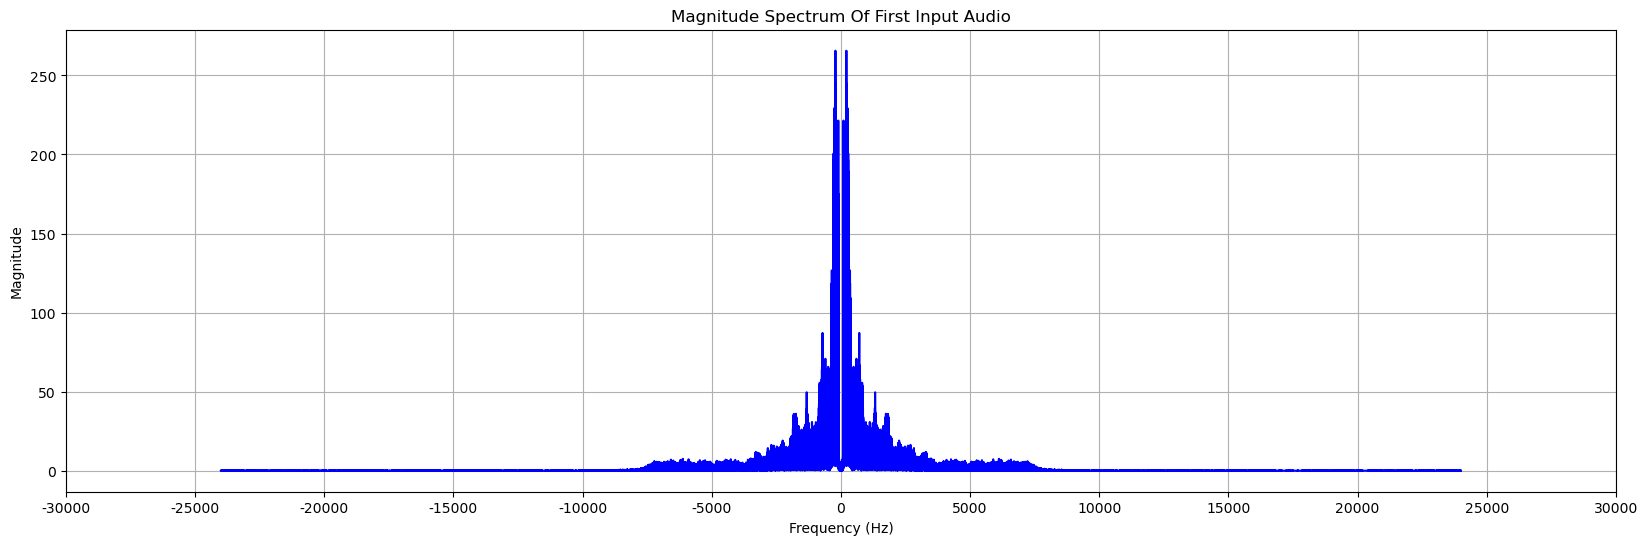

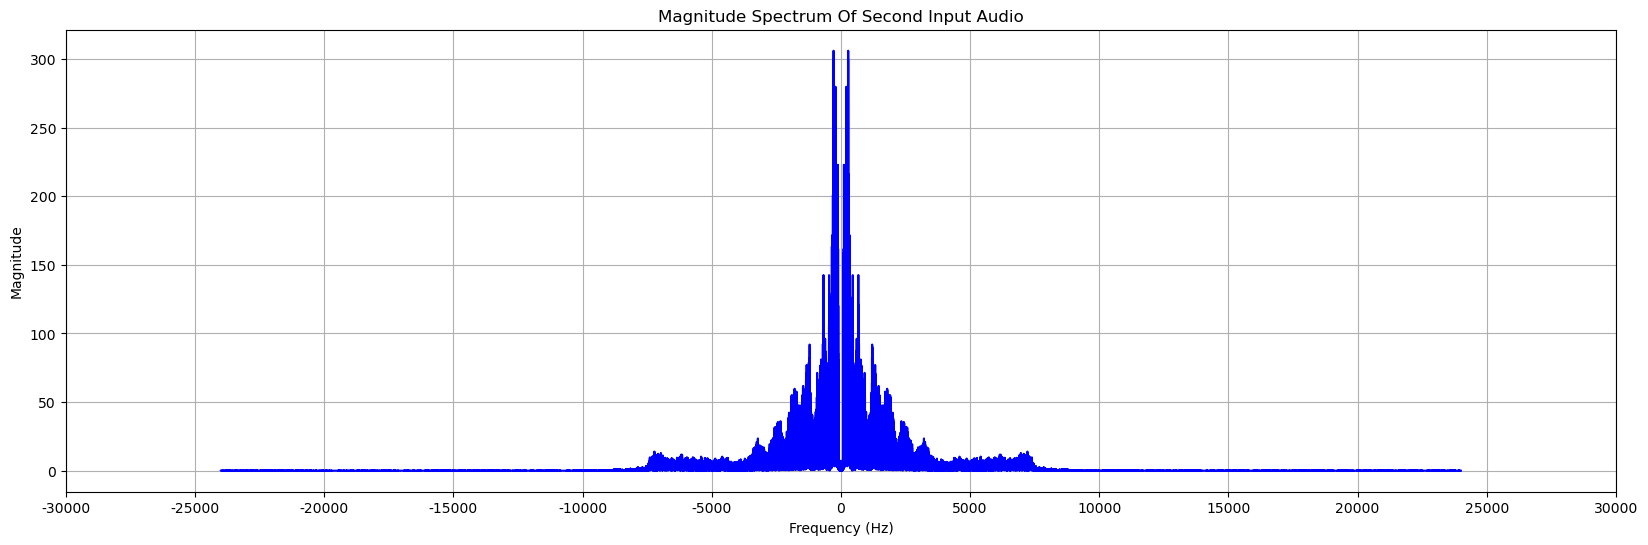

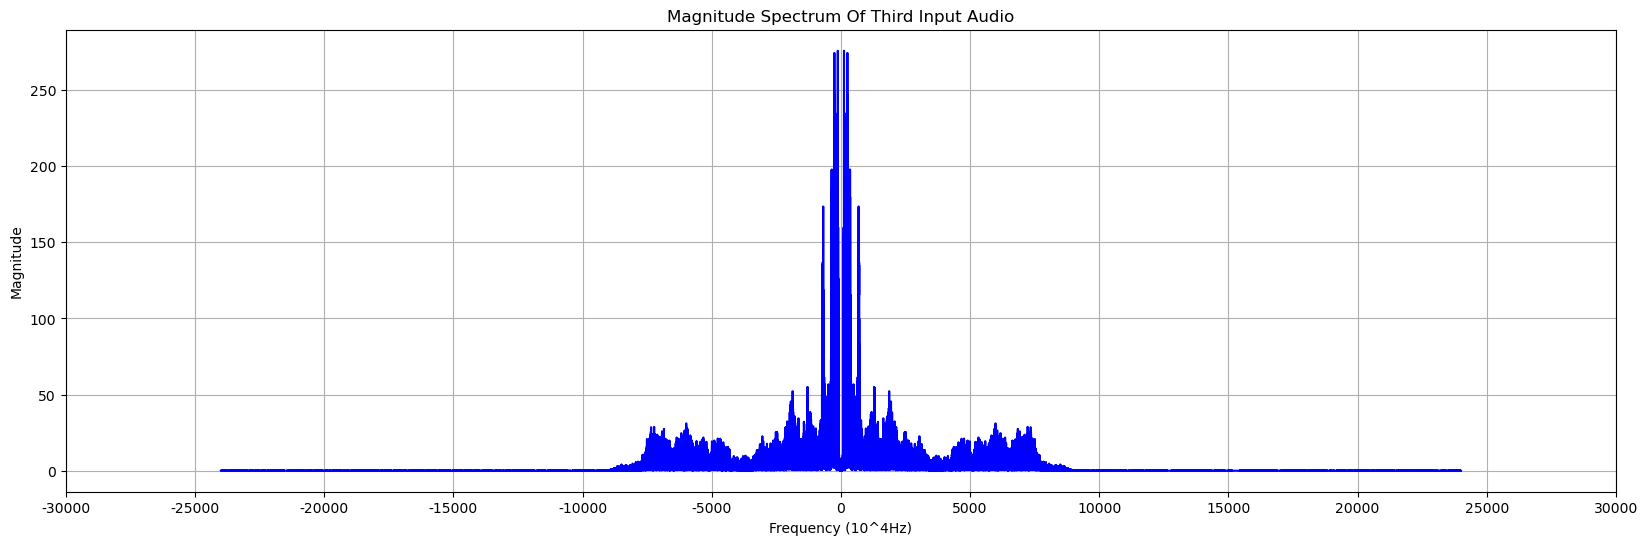

In [128]:
def convert_to_freq_domain(filename):
    sample_rate, audio_data = wavfile.read(filename)
    if audio_data.dtype == np.int16:
        audio_data = audio_data / 32768.0  # Normalize to range [-1, 1]
    elif audio_data.dtype == np.int32:
        audio_data = audio_data / 2147483648.0  # Normalize to range [-1, 1]

    # Compute FFT (for both positive and negative frequencies)
    n = len(audio_data)
    fft_result = np.fft.fft(audio_data)  # Compute the FFT (complex result)

    # Shift the zero frequency component to the center
    fft_result_shifted = np.fft.fftshift(fft_result)

    # Create the frequency axis (symmetric around zero)
    frequencies = np.fft.fftshift(np.fft.fftfreq(n, d=1 / sample_rate))

    # Compute the magnitude of the FFT (absolute value)
    fft_magnitude = np.abs(fft_result_shifted)

    return frequencies, fft_magnitude


def plot_signal(frequencies, signal, title, xlabel, ylabel, freq_step=5000):
    plt.figure(figsize=(20, 6))
    plt.plot(frequencies, signal, color="blue")
    plt.title(title)
    plt.xlabel(xlabel)  # Keep the xlabel as 'Frequency (Hz)'
    plt.ylabel(ylabel)
    plt.grid()

    # Set the frequency axis ticks at intervals of `freq_step` (5000 Hz in this case)
    tick_positions = np.arange(-30000, 30001, freq_step)  # From -30000 Hz to 30000 Hz
    tick_labels = np.arange(
        -30000, 31000, 5000
    )  # Labels from -25 to 25 (in units of 5000 Hz)

    plt.xticks(tick_positions, tick_labels)  # Use the tick positions and labels

    # Optionally, adjust the limits to focus on a specific frequency range
    plt.xlim(-30000, 30000)  # Focus on the range from -30000 Hz to 30000 Hz

    plt.show()


first_signal_sample_rate, first_signal_audio_data = wavfile.read(first_signal)
frequencies, fft_magnitude = convert_to_freq_domain(first_signal)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum Of First Input Audio",
    "Frequency (Hz)",
    "Magnitude",
)

second_signal_sample_rate, second_signal_audio_data = wavfile.read(second_signal)
frequencies, fft_magnitude = convert_to_freq_domain(second_signal)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum Of Second Input Audio",
    "Frequency (Hz)",
    "Magnitude",
)

third_signal_sample_rate, third_signal_audio_data = wavfile.read(third_signal)
frequencies, fft_magnitude = convert_to_freq_domain(third_signal)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum Of Third Input Audio",
    "Frequency (10^4Hz)",
    "Magnitude",
)

Applying LPF to limit max frequency

In [129]:
def butter_lowpass(cutoff, samplingFrequency, order=5):
    nyquist = 0.5 * samplingFrequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def apply_lowpass_filter(data, cutoff, samplingFrequency, order=5):
    b, a = butter_lowpass(cutoff, samplingFrequency, order=order)
    # Use filtfilt for zero-phase filtering
    filtered_data = filtfilt(b, a, data)
    return filtered_data


cutoff_frequency = 4000

first_signal_audio_data = first_signal_audio_data.astype(
    np.float32
)  # Convert to float for processing
second_signal_audio_data = second_signal_audio_data.astype(
    np.float32
)  # Convert to float for processing
third_signal_audio_data = third_signal_audio_data.astype(
    np.float32
)  # Convert to float for processing

# Apply Low-Pass Filter
first_signal_filtered_audio = apply_lowpass_filter(
    first_signal_audio_data, cutoff_frequency, first_signal_sample_rate
)
second_signal_filtered_audio = apply_lowpass_filter(
    second_signal_audio_data, cutoff_frequency, second_signal_sample_rate
)
third_signal_filtered_audio = apply_lowpass_filter(
    third_signal_audio_data, cutoff_frequency, third_signal_sample_rate
)

# Normalize filtered audio for saving
first_signal_filtered_audio = np.int16(
    first_signal_filtered_audio / np.max(np.abs(first_signal_filtered_audio)) * 32767
)
second_signal_filtered_audio = np.int16(
    second_signal_filtered_audio / np.max(np.abs(second_signal_filtered_audio)) * 32767
)
third_signal_filtered_audio = np.int16(
    third_signal_filtered_audio / np.max(np.abs(third_signal_filtered_audio)) * 32767
)

# Save filtered audios
filtered_filename = f"filtered_{first_signal}"
wavio.write(
    filtered_filename,
    first_signal_filtered_audio,
    first_signal_sample_rate,
    sampwidth=2,
)
print(f"Filtered audio saved to {filtered_filename}")

filtered_filename = f"filtered_{second_signal}"
wavio.write(
    filtered_filename,
    second_signal_filtered_audio,
    second_signal_sample_rate,
    sampwidth=2,
)
print(f"Filtered audio saved to {filtered_filename}")

filtered_filename = f"filtered_{third_signal}"
wavio.write(
    filtered_filename,
    third_signal_filtered_audio,
    third_signal_sample_rate,
    sampwidth=2,
)
print(f"Filtered audio saved to {filtered_filename}")

Filtered audio saved to filtered_input1.wav
Filtered audio saved to filtered_input2.wav
Filtered audio saved to filtered_input3.wav


Converting the filtered audio signal and plotting the magnitude spectrum

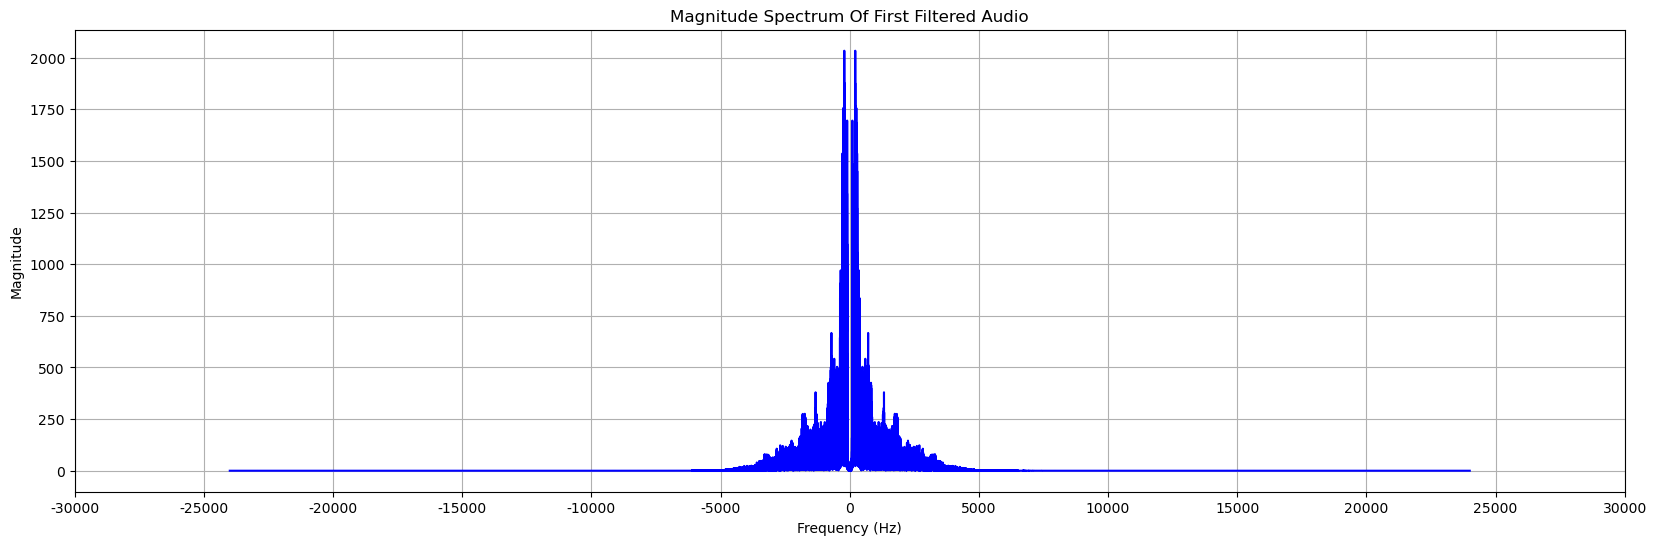

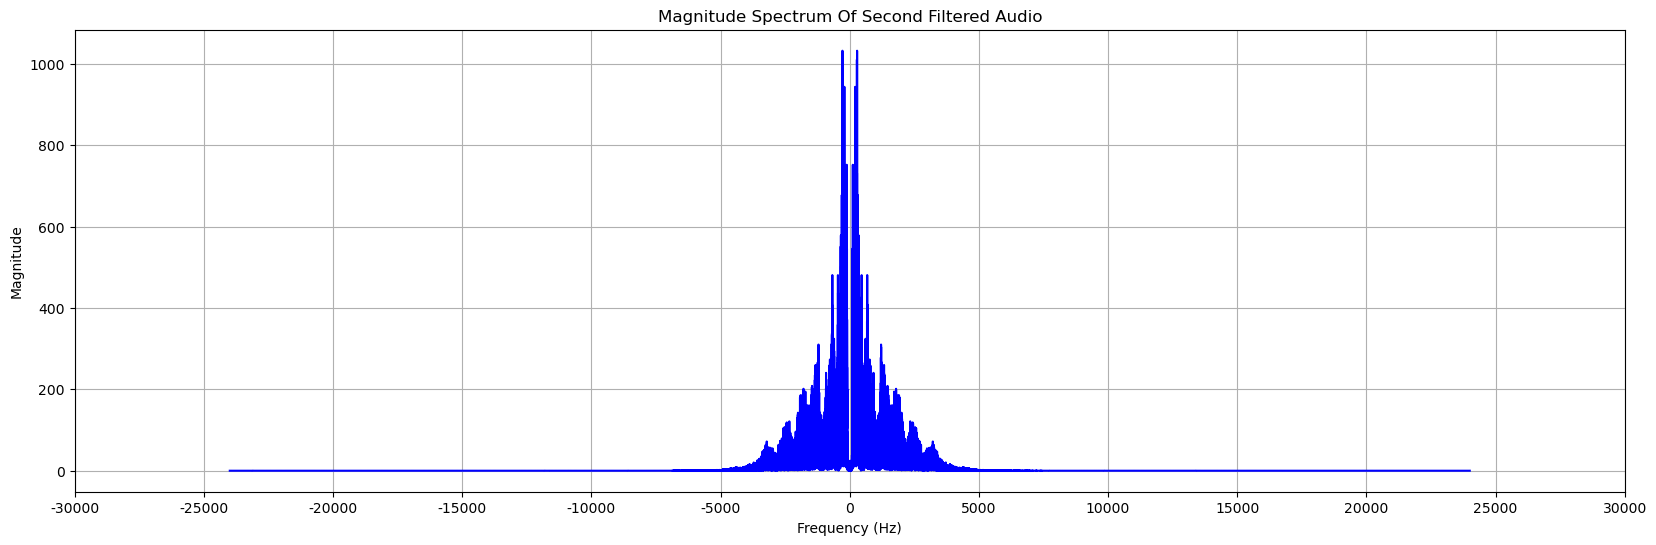

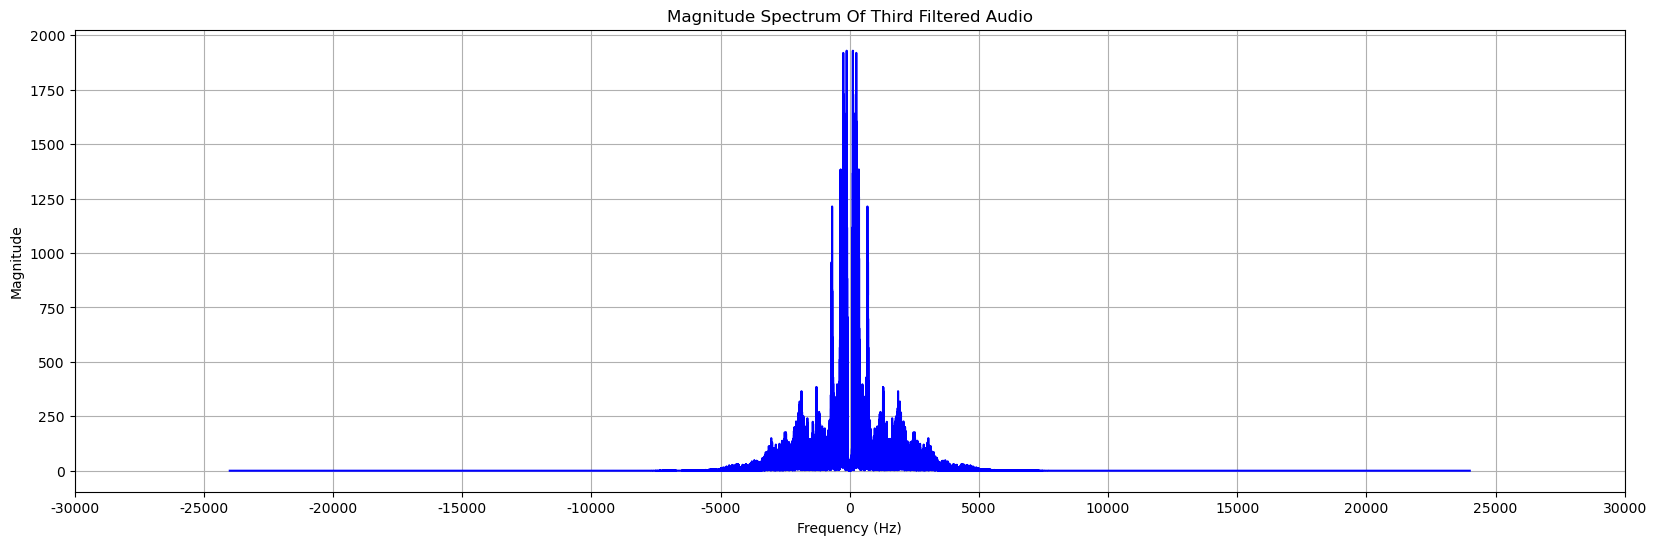

In [130]:
filtered_filename = f"filtered_{first_signal}"
frequencies, fft_magnitude = convert_to_freq_domain(filtered_filename)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum Of First Filtered Audio",
    "Frequency (Hz)",
    "Magnitude",
)

filtered_filename = f"filtered_{second_signal}"
frequencies, fft_magnitude = convert_to_freq_domain(filtered_filename)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum Of Second Filtered Audio",
    "Frequency (Hz)",
    "Magnitude",
)

filtered_filename = f"filtered_{third_signal}"
frequencies, fft_magnitude = convert_to_freq_domain(filtered_filename)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum Of Third Filtered Audio",
    "Frequency (Hz)",
    "Magnitude",
)

Apply SSB Modualation for the filtered audios

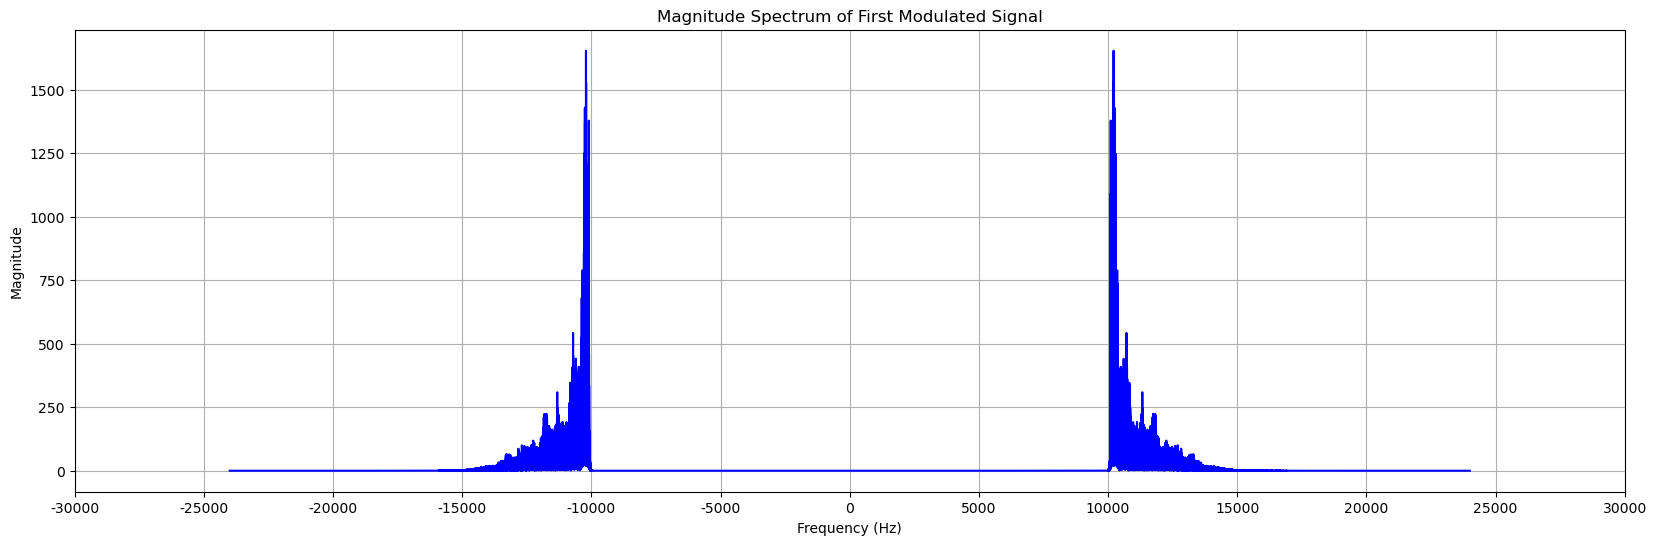

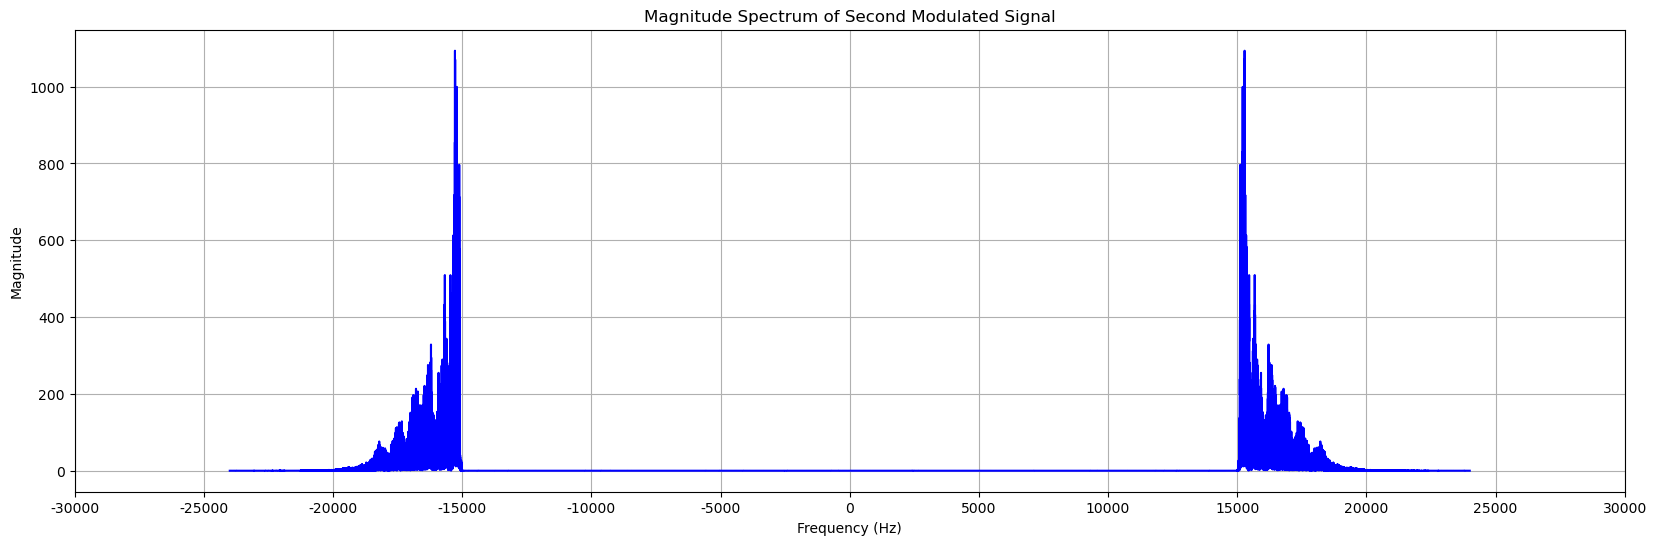

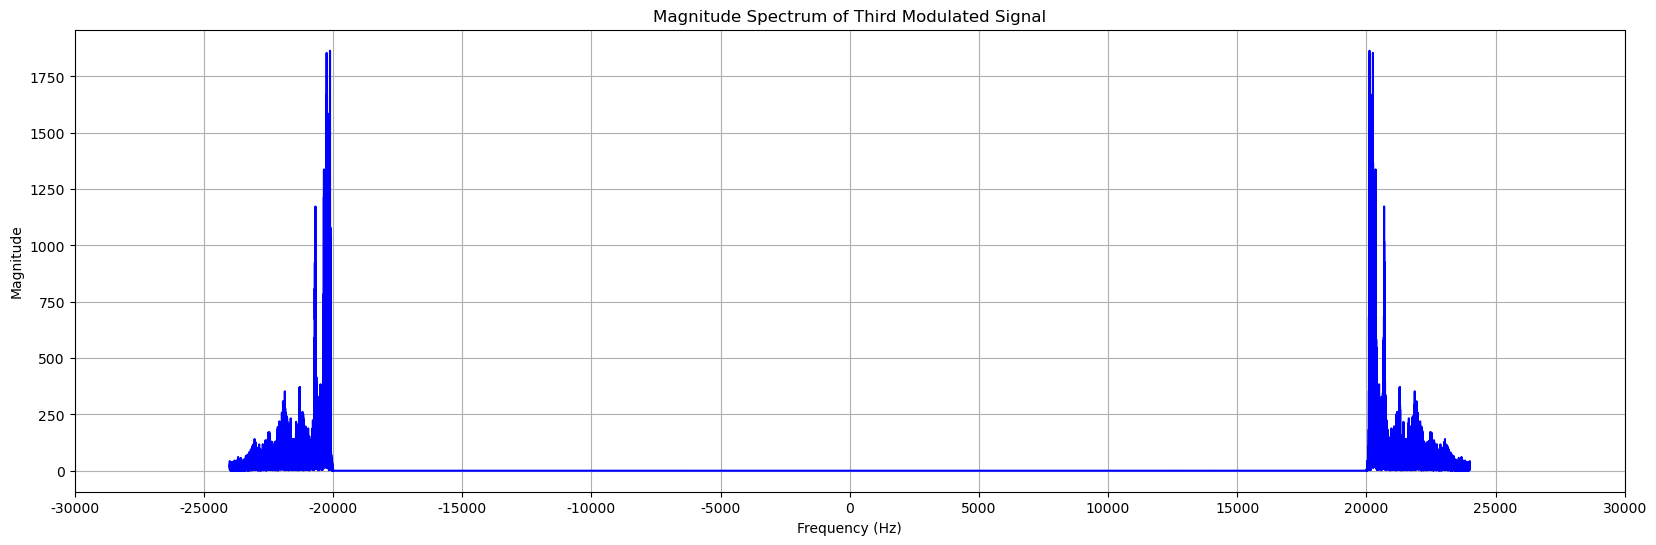

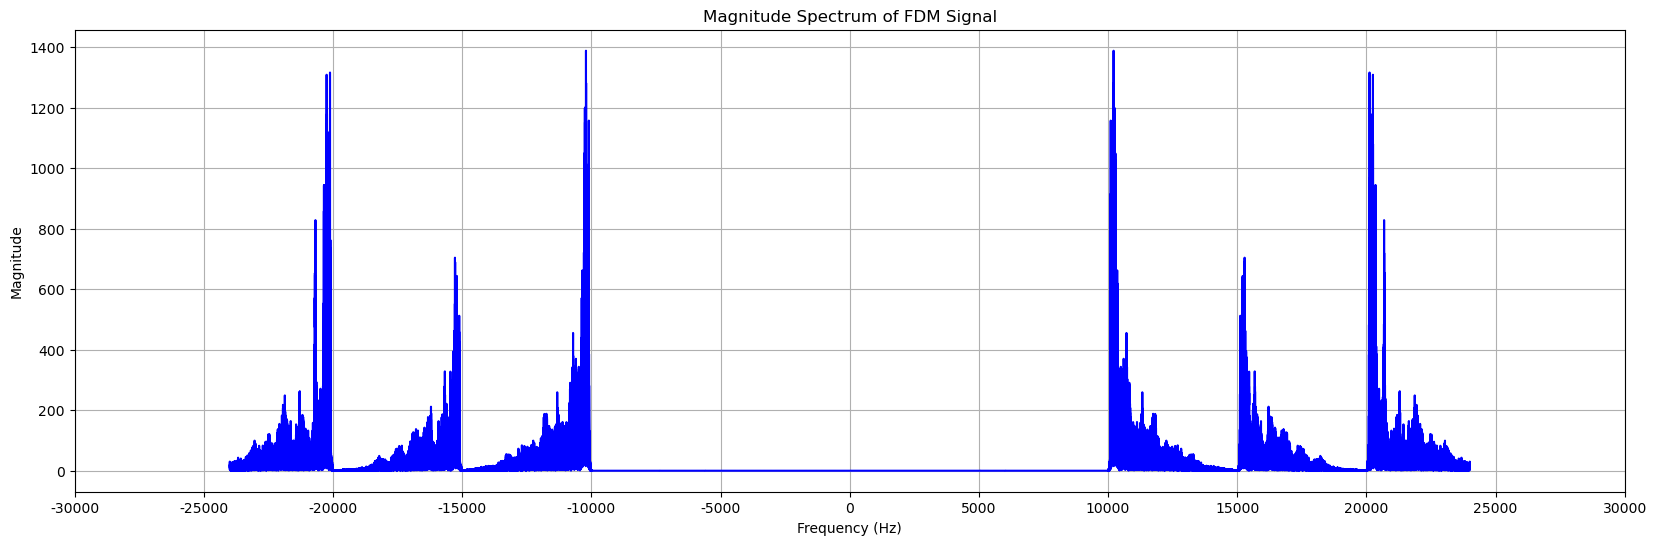

In [131]:
first_carrier_frequency, second_carrier_frequency, third_carrier_frequency = (
    10000,
    15000,
    20000,
)

# Creating the sample indices
(
    time_divisioned_first_signal,
    time_divisioned_second_signal,
    time_divisioned_third_signal,
) = (
    (np.arange(0, len(first_signal_filtered_audio)) / first_signal_sample_rate),
    (np.arange(0, len(second_signal_filtered_audio)) / second_signal_sample_rate),
    (np.arange(0, len(third_signal_filtered_audio)) / third_signal_sample_rate),
)

first_signal_analytic, second_signal_analytic, third_signal_analytic = (
    hilbert(first_signal_filtered_audio),
    hilbert(second_signal_filtered_audio),
    hilbert(third_signal_filtered_audio),
)

# SSB Modulation
ssb1, ssb2, ssb3 = (
    np.real(
        first_signal_analytic
        * np.exp(
            1j * 2 * np.pi * first_carrier_frequency * time_divisioned_first_signal
        )
    ),
    np.real(
        second_signal_analytic
        * np.exp(
            1j * 2 * np.pi * second_carrier_frequency * time_divisioned_second_signal
        )
    ),
    np.real(
        third_signal_analytic
        * np.exp(
            1j * 2 * np.pi * third_carrier_frequency * time_divisioned_third_signal
        )
    ),
)

first_signal_modulated_file = "modulated_input1.wav"
second_signal_modulated_file = "modulated_input2.wav"
third_signal_modulated_file = "modulated_input3.wav"

first_signal_modulated = np.int16(ssb1 / np.max(np.abs(ssb1)) * 32767)
second_signal_modulated = np.int16(ssb2 / np.max(np.abs(ssb2)) * 32767)
third_signal_modulated = np.int16(ssb3 / np.max(np.abs(ssb3)) * 32767)

wavio.write(
    first_signal_modulated_file,
    first_signal_modulated,
    first_signal_sample_rate,
    sampwidth=2,
)
wavio.write(
    second_signal_modulated_file,
    second_signal_modulated,
    second_signal_sample_rate,
    sampwidth=2,
)
wavio.write(
    third_signal_modulated_file,
    third_signal_modulated,
    third_signal_sample_rate,
    sampwidth=2,
)

frequencies, fft_magnitude = convert_to_freq_domain(first_signal_modulated_file)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of First Modulated Signal",
    "Frequency (Hz)",
    "Magnitude",
)


frequencies, fft_magnitude = convert_to_freq_domain(second_signal_modulated_file)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of Second Modulated Signal",
    "Frequency (Hz)",
    "Magnitude",
)


frequencies, fft_magnitude = convert_to_freq_domain(third_signal_modulated_file)
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of Third Modulated Signal",
    "Frequency (Hz)",
    "Magnitude",
)


fdm_signal = ssb1 + ssb2 + ssb3

fdm_filename = "fdm_signal.wav"
fdm_signal = np.int16(fdm_signal / np.max(np.abs(fdm_signal)) * 32767)

wavio.write(
    fdm_filename,
    fdm_signal,
    first_signal_sample_rate,
    sampwidth=2,
)

frequencies, fft_magnitude = convert_to_freq_domain(fdm_filename)

plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of FDM Signal",
    "Frequency (Hz)",
    "Magnitude",
)

Demodulating the signals

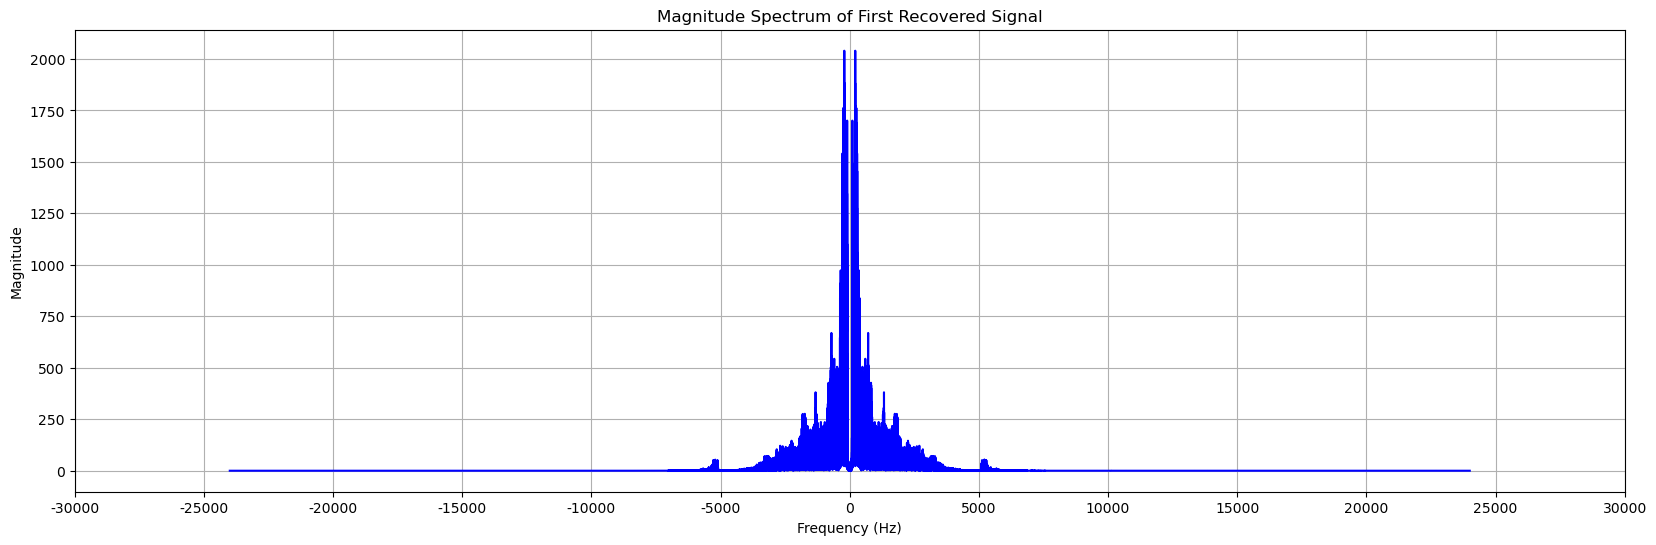

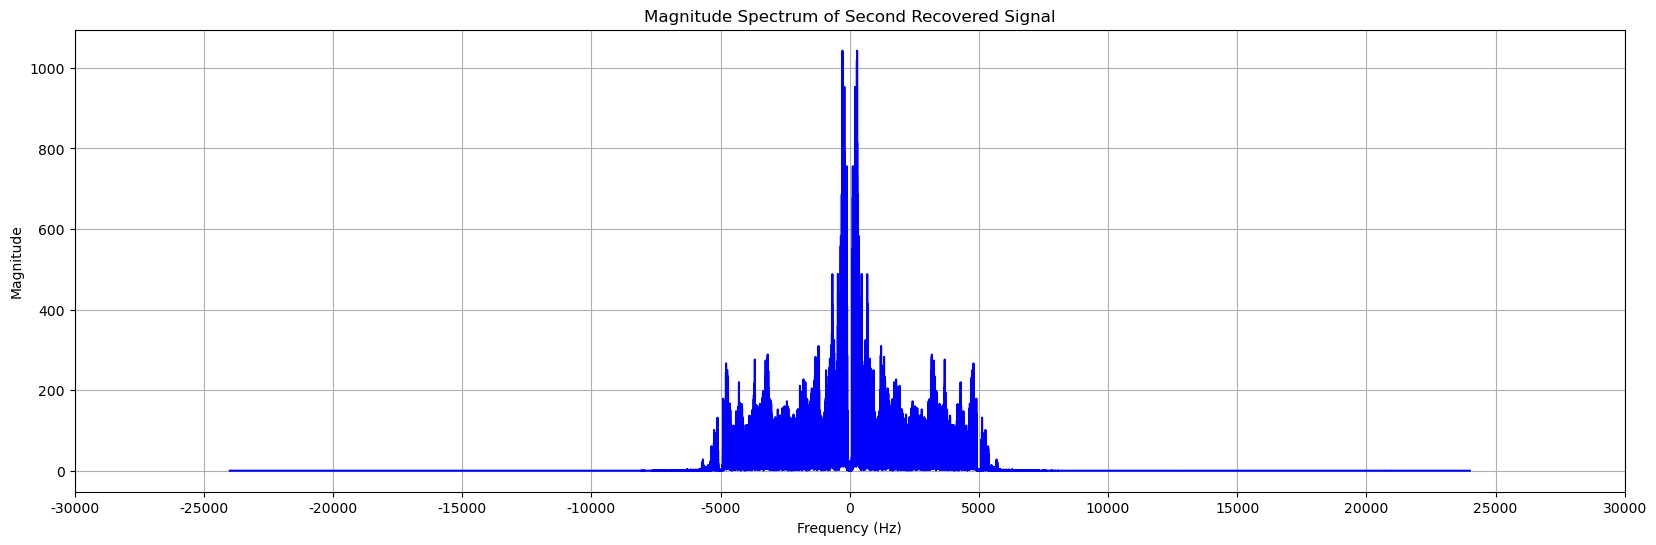

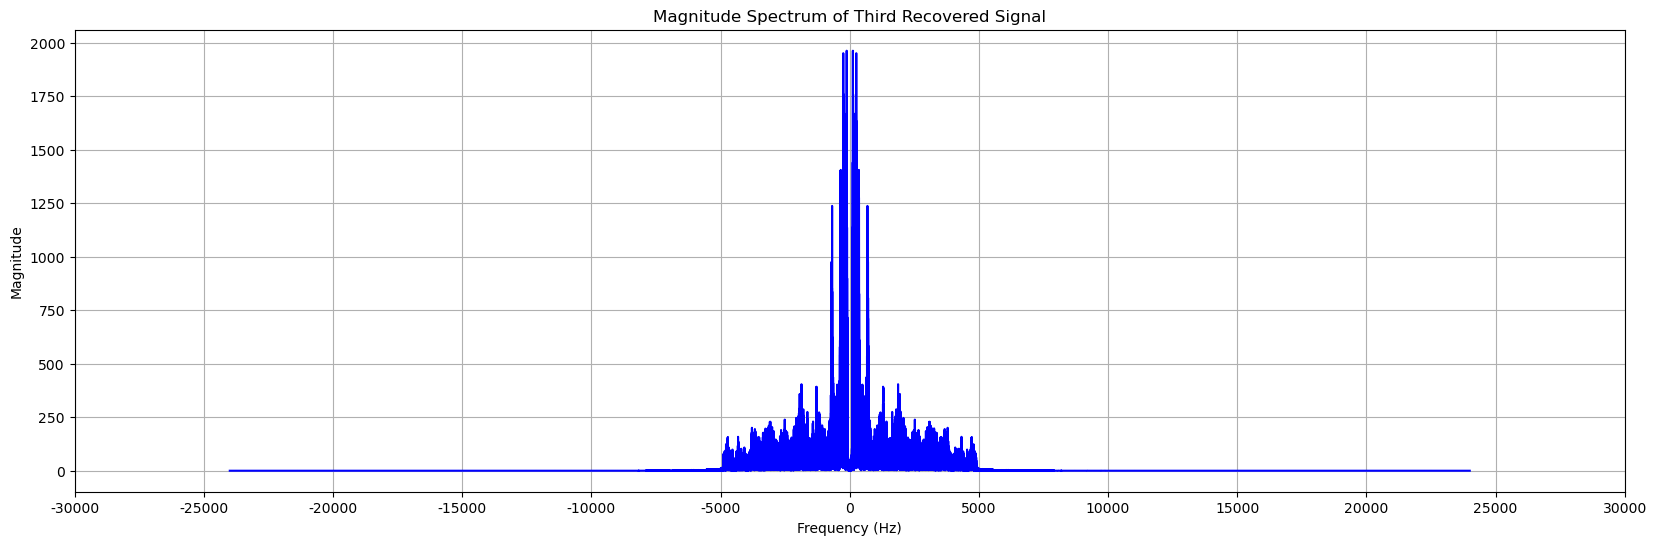

In [132]:
first_signal_demodulated = fdm_signal * np.cos(
    2 * np.pi * first_carrier_frequency * time_divisioned_first_signal
)
second_signal_demodulated = fdm_signal * np.cos(
    2 * np.pi * second_carrier_frequency * time_divisioned_second_signal
)
third_signal_demodulated = fdm_signal * np.cos(
    2 * np.pi * third_carrier_frequency * time_divisioned_third_signal
)

## Filter the demodulated signals
first_signal_recovered = apply_lowpass_filter(
    first_signal_demodulated, cutoff_frequency, first_signal_sample_rate
)
second_signal_recovered = apply_lowpass_filter(
    second_signal_demodulated, cutoff_frequency, second_signal_sample_rate
)
third_signal_recovered = apply_lowpass_filter(
    third_signal_demodulated, cutoff_frequency, third_signal_sample_rate
)

## Normalizing the demodulated signals
first_signal_recovered = np.int16(
    first_signal_recovered / np.max(np.abs(first_signal_recovered)) * 32767
)
second_signal_recovered = np.int16(
    second_signal_recovered / np.max(np.abs(second_signal_recovered)) * 32767
)
third_signal_recovered = np.int16(
    third_signal_recovered / np.max(np.abs(third_signal_recovered)) * 32767
)

wavio.write(
    "output1.wav",
    first_signal_recovered,
    first_signal_sample_rate,
    sampwidth=2,
)
wavio.write(
    "output2.wav",
    second_signal_recovered,
    second_signal_sample_rate,
    sampwidth=2,
)
wavio.write(
    "output3.wav",
    third_signal_recovered,
    third_signal_sample_rate,
    sampwidth=2,
)

first_signal_spectrum = np.abs(np.fft.fft(first_signal_recovered))
second_signal_spectrum = np.abs(np.fft.fft(second_signal_recovered))
third_signal_spectrum = np.abs(np.fft.fft(third_signal_recovered))

frequencies, fft_magnitude = convert_to_freq_domain("output1.wav")
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of First Recovered Signal",
    "Frequency (Hz)",
    "Magnitude",
)
frequencies, fft_magnitude = convert_to_freq_domain("output2.wav")
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of Second Recovered Signal",
    "Frequency (Hz)",
    "Magnitude",
)
frequencies, fft_magnitude = convert_to_freq_domain("output3.wav")
plot_signal(
    frequencies,
    fft_magnitude,
    "Magnitude Spectrum of Third Recovered Signal",
    "Frequency (Hz)",
    "Magnitude",
)